# DSLabs functions

In [63]:
%run "scripts/dslabs_functions.py"


# Data functions

In [64]:
%run "scripts/data_functions.py"

import pandas as pd
import numpy as np



data_functions lodaded


# Load

In [65]:
test_data=False
# test_data=False


file_tag = "Gira Bike"

train=pd.read_csv(f"data/df_gira_agg_2h_final_train.csv", decimal=".",  index_col='date', parse_dates=True,  infer_datetime_format=True)

test=pd.read_csv(f"data/df_gira_agg_2h_final_test.csv", decimal=".",  index_col='date', parse_dates=True,  infer_datetime_format=True)

target='target_station_load_rate'

test_split_threshold=0.9
# Prepare the training and testing data from dataframes with features and target
trnX = train.drop(columns=[target])
trnY = train[target]
tstX = test.drop(columns=[target])
tstY = test[target]


from numpy import arange

# Ensure no data leakage
assert not set(train.index).intersection(set(test.index)), "Data leakage detected: Train and test sets overlap."


train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4878 entries, 2022-01-01 14:00:00 to 2023-02-14 14:00:00
Data columns (total 12 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   temperature_2m                                               4878 non-null   float64
 1   rain_mm                                                      4878 non-null   float64
 2   wmo_weather_code                                             4878 non-null   float64
 3   wind_speed_10m                                               4878 non-null   float64
 4   is_holiday_lisbon                                            4878 non-null   float64
 5   target_station_status                                        4878 non-null   float64
 6   target_station_load_rate                                     4878 non-null   float64
 7   station_load_rate_ Rua do Arco Cego / Av. 

In [5]:
print("Train shape:", train.shape)
print("Train date range:", train.index.min(), "to", train.index.max())

print("\nTest shape:", test.shape)
print("Test date range:", test.index.min(), "to", test.index.max())


Train shape: (4878, 12)
Train date range: 2022-01-01 14:00:00 to 2023-02-14 14:00:00

Test shape: (542, 12)
Test date range: 2023-02-14 16:00:00 to 2023-03-31 22:00:00


In [6]:
display(trnX.head())
display(trnY.head())

,temperature_2m,rain_mm,wmo_weather_code,wind_speed_10m,is_holiday_lisbon,target_station_status,station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima,station_load_rate_ Av. Rovisco Pais / Av. Manuel da Maia,station_load_rate_ Praça de Londres,station_load_rate_ Av. Duque de Ávila / Jardim Arco Do Cego,station_load_rate_ Av. Barbosa Du Bocage / Rua Arco do Cego
date,,,,,,,,,,,
2022-01-01 14:00:00,0.229002,0.0,0.000000,0.048146,0.0,0.0,-0.597770,-0.413569,0.283739,0.034259,-0.177924
2022-01-01 16:00:00,-0.362586,0.0,-0.059009,0.064195,0.0,0.0,0.673013,-1.159614,-0.865405,-0.425792,-0.303518
2022-01-01 18:00:00,-0.534338,0.0,0.059009,0.224681,0.0,0.0,-0.434742,0.689281,-1.014369,-0.210449,0.130827
2022-01-01 20:00:00,-0.019083,0.0,0.000000,0.192584,0.0,0.0,0.058523,0.417623,0.443343,0.743912,0.000000
2022-01-01 22:00:00,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.497445,-0.085147,0.088669,0.156613,0.172691


date
2022-01-01 14:00:00   -0.595851
2022-01-01 16:00:00   -0.486409
2022-01-01 18:00:00   -0.162136
2022-01-01 20:00:00    0.000000
2022-01-01 22:00:00    0.000000
Name: target_station_load_rate, dtype: float64

# Simple Average

## Simple Average - Evaluate

In [31]:
from math import sqrt
from matplotlib.pyplot import subplots
from pandas import Series

def plot_forecasting_eval(trn: Series, tst: Series, prd_trn: Series, prd_tst: Series, title: str = "") -> list:
    # Calculate evaluation metrics
    ev1: dict = {
        "RMSE": [sqrt(FORECAST_MEASURES["MSE"](trn, prd_trn)), sqrt(FORECAST_MEASURES["MSE"](tst, prd_tst))],
        "MAE": [FORECAST_MEASURES["MAE"](trn, prd_trn), FORECAST_MEASURES["MAE"](tst, prd_tst)],
    }
    ev2: dict = {
        "MAPE": [FORECAST_MEASURES["MAPE"](trn, prd_trn), FORECAST_MEASURES["MAPE"](tst, prd_tst)],
        "R2": [FORECAST_MEASURES["R2"](trn, prd_trn), FORECAST_MEASURES["R2"](tst, prd_tst)],
    }

    # Print metric values and sizes of train and test sets
    print(f"\n### Forecasting Evaluation Metrics ({title}) ###")
    print(f"Train size: {len(trn)}")
    print(f"Test size: {len(tst)}")
    print(f"RMSE - Train: {ev1['RMSE'][0]:.4f}, Test: {ev1['RMSE'][1]:.4f}")
    print(f"MAE - Train: {ev1['MAE'][0]:.4f}, Test: {ev1['MAE'][1]:.4f}")
    print(f"MAPE - Train: {ev2['MAPE'][0]:.4f}, Test: {ev2['MAPE'][1]:.4f}")
    print(f"R2 - Train: {ev2['R2'][0]:.4f}, Test: {ev2['R2'][1]:.4f}\n")

    # Plot the metrics
    HEIGHT = 6
    fig, axs = subplots(1, 2, figsize=(1.5 * HEIGHT, 0.75 * HEIGHT), squeeze=True)
    fig.suptitle(title)
    plot_multibar_chart(["train", "test"], ev1, ax=axs[0], title="Scale-dependent error", percentage=False)
    plot_multibar_chart(["train", "test"], ev2, ax=axs[1], title="Percentage error", percentage=True)

    return axs

In [8]:

def plot_single_model_evaluation(train: Series, test: Series, prd_train: Series, prd_test: Series, title: str = ""):
    # Calculate performance metrics
    metrics = {
        "MAE": [
            mean_absolute_error(train, prd_train),
            mean_absolute_error(test, prd_test),
        ],
        "MSE": [
            mean_squared_error(train, prd_train),
            mean_squared_error(test, prd_test),
        ],
        "RMSE": [
            mean_squared_error(train, prd_train, squared=False),
            mean_squared_error(test, prd_test, squared=False),
        ],
        "R²": [
            r2_score(train, prd_train),
            r2_score(test, prd_test),
        ]
    }

    # Create a DataFrame from the metrics dictionary
    performance_df = pd.DataFrame(metrics, index=["Train", "Test"]).T
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(title, fontsize=16)
    
    # Plot scale-dependent errors
    scale_dependent_errors = ["MAE", "MSE", "RMSE"]
    scale_dependent_data = performance_df.loc[scale_dependent_errors]
    ax = axs[0]
    ax.set_title("Scale-dependent errors")
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    bar_width = 0.2  # Adjusted bar width for more spacing
    index = np.arange(len(scale_dependent_data.columns))
    for i, metric in enumerate(scale_dependent_data.index):
        bars = ax.bar(index + i * bar_width * 1.5, scale_dependent_data.loc[metric], bar_width, label=metric)
        ax.bar_label(bars, fmt='%.2f')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(scale_dependent_data.columns)
    ax.legend()
    
    # Plot percentage errors
    percentage_errors = ["R²"]
    percentage_data = performance_df.loc[percentage_errors]
    ax = axs[1]
    ax.set_title("Percentage errors")
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    bar_width = 0.35
    index = np.arange(len(percentage_data.columns))
    for i, metric in enumerate(percentage_data.index):
        bars = ax.bar(index + i * bar_width, percentage_data.loc[metric], bar_width, label=metric)
        ax.bar_label(bars, fmt='%.2f')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(percentage_data.columns)
    ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_performance_metrics(metrics: dict, title: str = ""):
    # Create a DataFrame from the metrics dictionary
    performance_df = pd.DataFrame(metrics)
    
    # Separate scale-dependent errors and percentage errors
    scale_dependent_errors = ["MAE", "MSE", "RMSE"]
    percentage_errors = ["R²"]
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(title, fontsize=16)
    
    # Plot scale-dependent errors
    scale_dependent_data = performance_df[["Model"] + scale_dependent_errors].set_index("Model").T
    ax = axs[0]
    ax.set_title("Scale-dependent errors")
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    bar_width = 0.2  # Adjusted bar width for more spacing
    index = np.arange(len(scale_dependent_data.columns))
    for i, metric in enumerate(scale_dependent_data.index):
        bars = ax.bar(index + i * bar_width * 1.5, scale_dependent_data.loc[metric], bar_width, label=metric)
        ax.bar_label(bars, fmt='%.2f')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(scale_dependent_data.columns)
    ax.legend()
    
    # Plot percentage errors
    percentage_data = performance_df[["Model"] + percentage_errors].set_index("Model").T
    ax = axs[1]
    ax.set_title("Percentage errors")
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    bar_width = 0.35
    index = np.arange(len(percentage_data.columns))
    for i, metric in enumerate(percentage_data.index):
        bars = ax.bar(index + i * bar_width, percentage_data.loc[metric], bar_width, label=metric)
        ax.bar_label(bars, fmt='%.2f')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(percentage_data.columns)
    ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [9]:
from sklearn.base import RegressorMixin


class SimpleAvgRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.mean: float = 0.0
        return

    def fit(self, X: Series):
        self.mean = X.mean()
        return

    def predict(self, X: Series) -> Series:
        prd: list = len(X) * [self.mean]
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series


### Forecasting Evaluation Metrics (Gira Bike - Simple Average Forecasting Evaluation) ###
Train size: 4878
Test size: 542
RMSE - Train: 0.7283, Test: 0.7414
MAE - Train: 0.4354, Test: 0.4389
MAPE - Train: 12663053773.5094, Test: 11185467346.4009
R2 - Train: 0.0000, Test: -0.0000



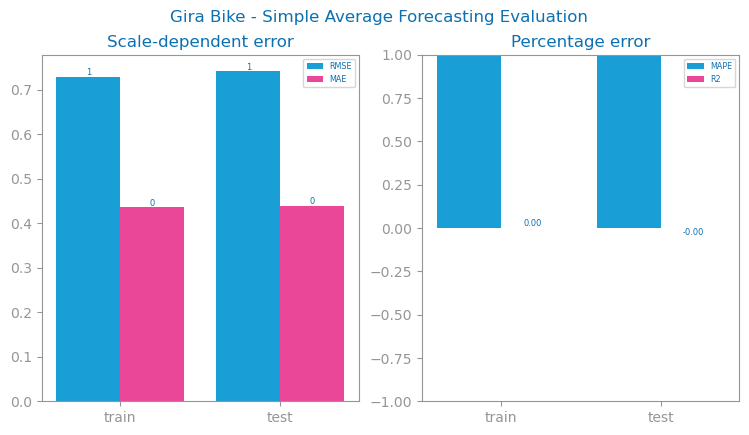

In [10]:

import pandas as pd

# Fit the Model
model = SimpleAvgRegressor()
model.fit(pd.Series(trnY))

# Predict the training and testing data
prd_trn = pd.Series(model.predict(pd.Series(trnY)), index=train.index)
prd_tst = pd.Series(model.predict(pd.Series(tstY)), index=test.index)

# Plot the forecasting evaluation
plot_forecasting_eval(train[target], test[target], prd_trn, prd_tst, title=f"{file_tag} - Simple Average Forecasting Evaluation")
savefig(f"images/{file_tag}_simple_average_evaluation.png")

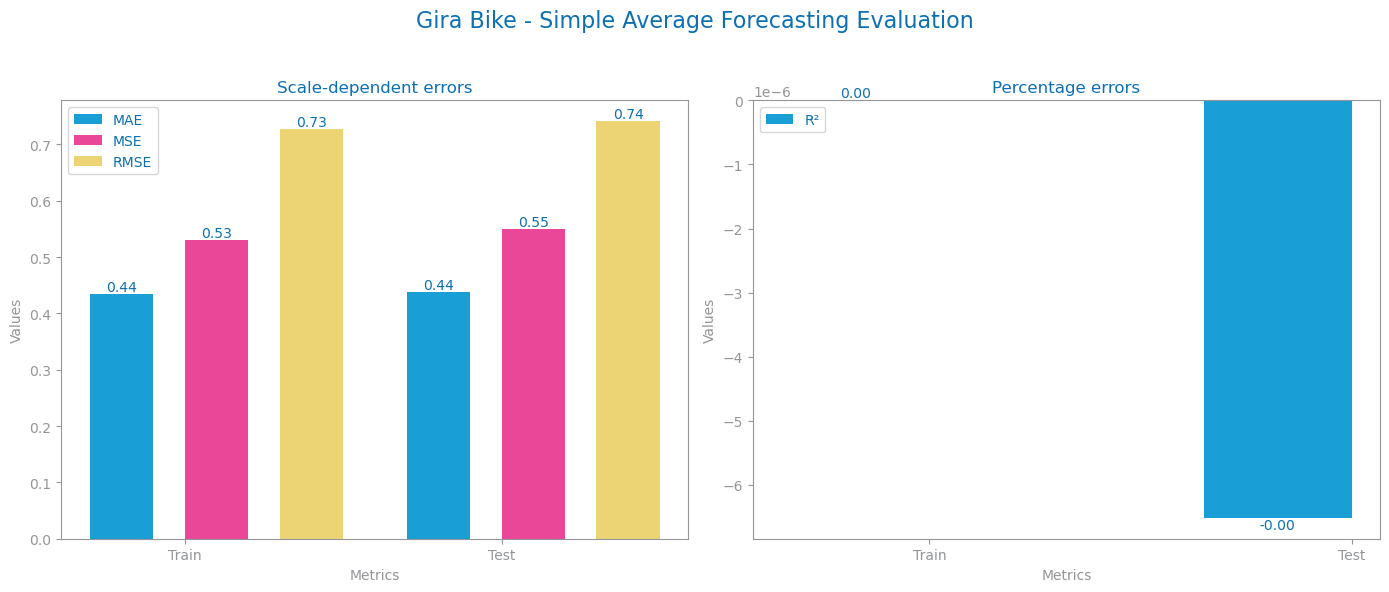

<Figure size 640x480 with 0 Axes>

In [23]:

import pandas as pd

# Fit the Model
model = SimpleAvgRegressor()
model.fit(pd.Series(trnY))

# Predict the training and testing data
prd_trn = pd.Series(model.predict(pd.Series(trnY)), index=train.index)
prd_tst = pd.Series(model.predict(pd.Series(tstY)), index=test.index)

# Plot the forecasting evaluation
plot_single_model_evaluation(train[target], test[target], prd_trn, prd_tst, title=f"{file_tag} - Simple Average Forecasting Evaluation")
savefig(f"images/{file_tag}_simple_average_evaluation.png")

## Simple Average - Forecasting

<Axes: xlabel='Date', ylabel='target_station_load_rate'>

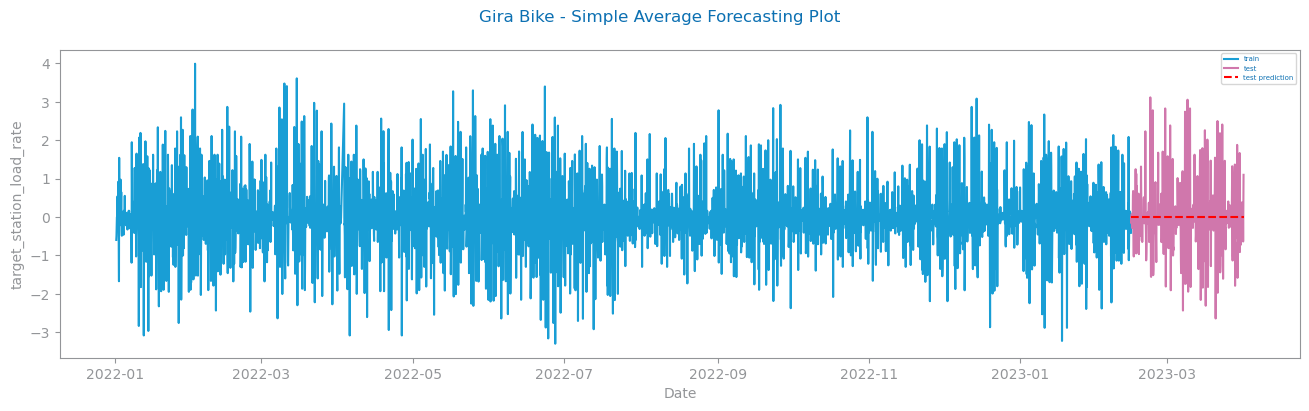

In [12]:
## Simple Average Forecasting
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - Simple Average Forecasting Plot",
    xlabel='Date',
    ylabel=target,
)

## Analysis - Results from Model Implementation

# Persistence Model
- The Persistence model just predicts the outcome to be the same as the last value seen. Again, for implementing it, we extended the sklearn class RegressorMixin, by redifining the fit and predict again.

Note that the more informed persistence model is the one that is able to predict just one step ahead - we call it the PersistenceOptimistRegressor and implement it as follows:



- Types of Persistence models:
    - Simple Persistence	- Uses the last observed value as the prediction (ŷ(t+1) = y(t)).
    - Optimistic Persistence (One-step behind) - 	Shifts past values forward, using the last training value as the first test prediction.
    - Realistic Persistence (Long Term)	- Incorporates trends and adjustments, using weighted averages or moving averages.    

- One Step Behind utiliza o último valor observado para prever o próximo instante. 
    - Este método é adequado para previsões de curto prazo em séries temporais estacionárias.
 - Long-Term Persistence assume que o último valor conhecido da série permanecerá constante para todas as previsões futuras, sendo representado pela fórmula.
    - Este modelo é mais indicado para previsões de longo prazo em variáveis que tendem a manter-se estáveis ao longo do tempo.

## Persistence Evaluate

In [13]:
from pandas import Series
from sklearn.base import RegressorMixin


class PersistenceOptimistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last: float = 0.0
        return

    def fit(self, X: Series):
        self.last = X.iloc[-1]
        # print(self.last)
        return

    def predict(self, X: Series):
        prd: list = X.shift().values.ravel()
        prd[0] = self.last
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series


class PersistenceOneStepAhead(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.y = None

    def fit(self, y: Series):
        self.y = y

    def predict(self, y):
        if isinstance(y, Series):
            prd = self.y.shift(1)
            prd.iloc[0] = self.y.iloc[0]  # Set the first value to the first value of the original series
        else:
            prd = np.roll(self.y, 1)
            prd[0] = self.y[0]
        return prd

### Persistence One-step behind (Optimistic)


### Forecasting Evaluation Metrics (Gira Bike - Persistence One-step Behind Evaluation) ###
Train size: 4878
Test size: 542
RMSE - Train: 1.0100, Test: 0.9777
MAE - Train: 0.6435, Test: 0.6032
MAPE - Train: 149965121143749.6250, Test: 99256978716235.9844
R2 - Train: -0.9233, Test: -0.7391



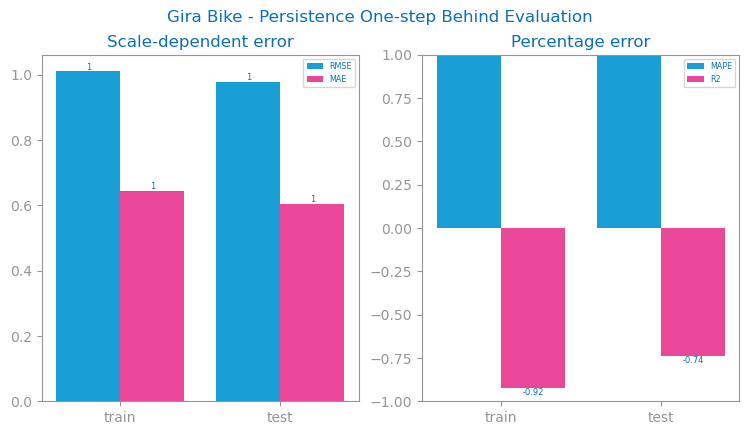

In [14]:

# Fit the Model
model = PersistenceOptimistRegressor()
model.fit(trnY)

# Predict the training and testing data
prd_trn_opt = Series(model.predict(trnY), index=train.index)
prd_tst_opt = Series(model.predict(tstY), index=test.index)

# Plot the forecasting evaluation
plot_forecasting_eval(train[target], test[target], prd_trn_opt, prd_tst_opt, title=f"{file_tag} - Persistence One-step Behind Evaluation")
savefig(f"{file_tag}_persitence_optimist_evaluation.png")

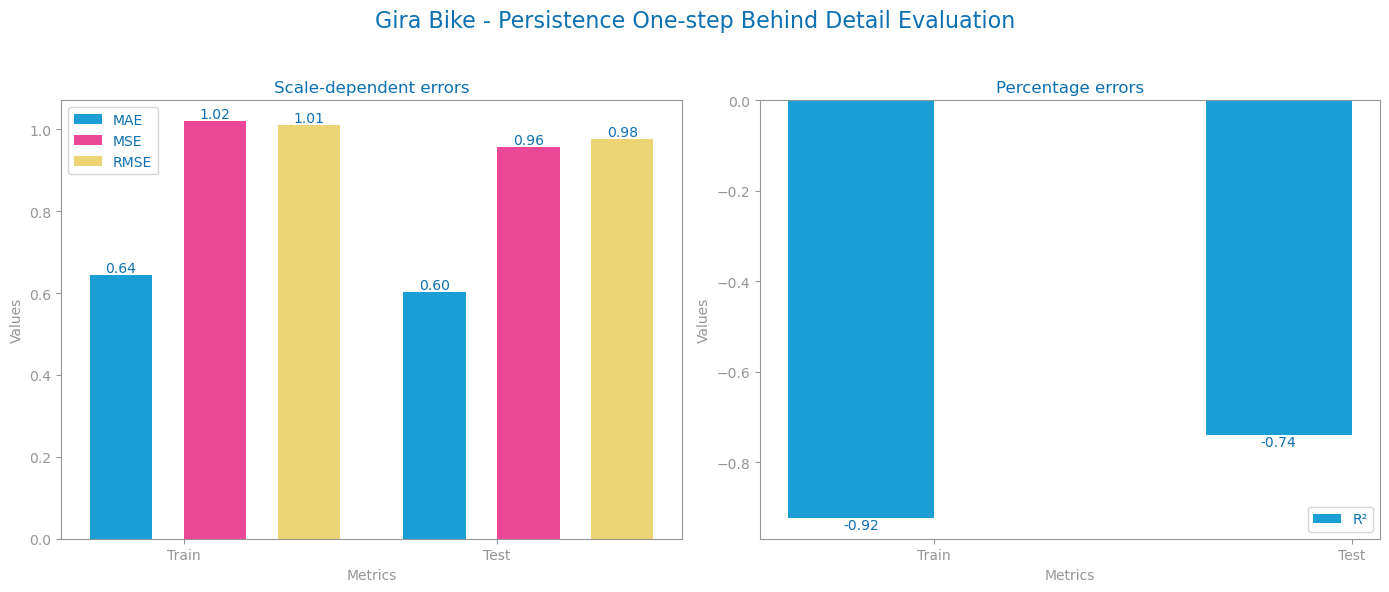

<Figure size 640x480 with 0 Axes>

In [122]:

# Fit the Model
model = PersistenceOptimistRegressor()
model.fit(trnY)

# Predict the training and testing data
prd_trn_opt = Series(model.predict(trnY), index=train.index)
prd_tst_opt = Series(model.predict(tstY), index=test.index)

# Plot the forecasting evaluation
plot_single_model_evaluation(train[target], test[target], prd_trn_opt, prd_tst_opt, title=f"{file_tag} - Persistence One-step Behind Detail Evaluation")
savefig(f"images/{file_tag}_persitence_optimist_evaluation.png")

#### Persistence Optimist Plot

<Axes: xlabel='Date', ylabel='target_station_load_rate'>

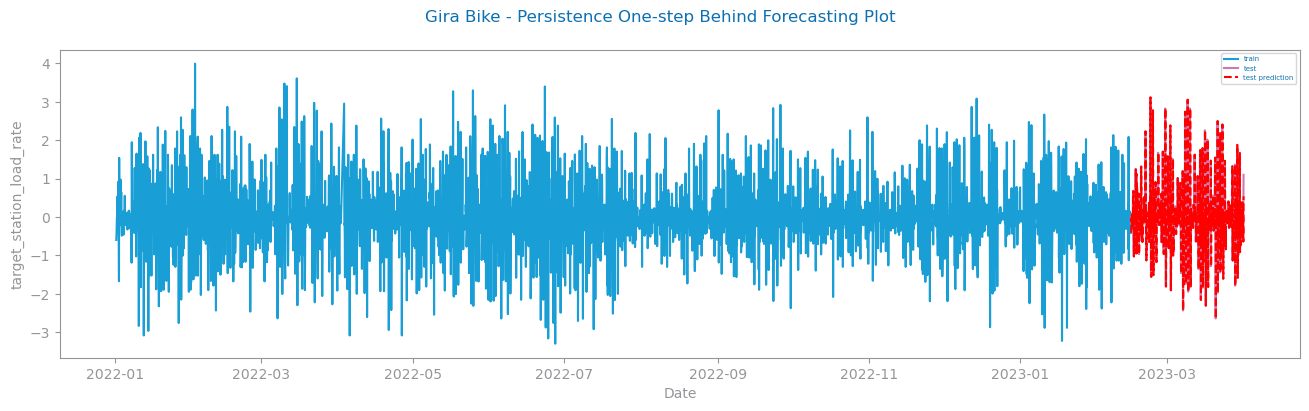

In [15]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst_opt,
    title=f"{file_tag} - Persistence One-step Behind Forecasting Plot",
    xlabel='Date',
    ylabel=target,
)

In [102]:
train.tail(5)

,temperature_2m,rain_mm,wmo_weather_code,wind_speed_10m,is_holiday_lisbon,target_station_status,target_station_load_rate,station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima,station_load_rate_ Av. Rovisco Pais / Av. Manuel da Maia,station_load_rate_ Praça de Londres,station_load_rate_ Av. Duque de Ávila / Jardim Arco Do Cego,station_load_rate_ Av. Barbosa Du Bocage / Rua Arco do Cego
date,,,,,,,,,,,,
2023-02-14 06:00:00,-0.057250,0.0,0.118018,0.080243,0.0,0.0,0.121602,-0.380399,-0.158129,-0.266006,0.362168,0.000000
2023-02-14 08:00:00,0.229002,0.0,-0.118018,0.320973,0.0,0.0,-0.170243,-1.053412,-2.388157,-1.152692,-0.195766,0.612268
2023-02-14 10:00:00,0.629755,0.0,0.000000,0.353071,0.0,0.0,-0.012160,-1.028331,0.093256,-0.414969,-0.166401,-0.225022
2023-02-14 12:00:00,0.458004,0.0,0.000000,0.609849,0.0,0.0,0.060801,0.075244,0.072983,0.177337,0.332803,-0.225022
2023-02-14 14:00:00,0.305336,0.0,0.177028,-0.064195,0.0,0.0,-0.409394,1.095214,2.104335,-0.294380,0.464945,2.129856


In [103]:
test.head(5)

,temperature_2m,rain_mm,wmo_weather_code,wind_speed_10m,is_holiday_lisbon,target_station_status,target_station_load_rate,station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima,station_load_rate_ Av. Rovisco Pais / Av. Manuel da Maia,station_load_rate_ Praça de Londres,station_load_rate_ Av. Duque de Ávila / Jardim Arco Do Cego,station_load_rate_ Av. Barbosa Du Bocage / Rua Arco do Cego
date,,,,,,,,,,,,
2023-02-14 16:00:00,-0.057250,0.000000,0.000000,0.000000,0.0,0.0,-0.036481,0.275894,-1.613729,0.060295,-0.107671,1.208837
2023-02-14 18:00:00,-0.248085,0.000000,0.000000,-0.304925,0.0,0.0,-0.162136,0.000000,-0.016218,1.181066,-1.331211,-1.669346
2023-02-14 20:00:00,-0.381670,2.302924,2.950462,0.320973,0.0,0.0,0.068908,0.238272,0.774428,0.219898,0.553040,-0.062797
2023-02-14 22:00:00,-0.019083,-0.460585,0.000000,0.032097,0.0,0.0,-0.109442,0.957267,0.563589,0.489451,-0.308332,-0.068030
2023-02-15 00:00:00,-0.038167,2.302924,0.472074,-0.320973,0.0,0.0,-0.283739,0.267533,-0.056764,-0.425609,0.254496,-0.287818


In [105]:
prd_tst_opt.head(5)

date
2023-02-14 16:00:00   -0.409394
2023-02-14 18:00:00   -0.036481
2023-02-14 20:00:00   -0.162136
2023-02-14 22:00:00    0.068908
2023-02-15 00:00:00   -0.109442
dtype: float64

### Persistence Long Term (Realistic)

In [16]:
class PersistenceRealistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last = 0
        self.estimations = [0]
        self.obs_len = 0

    def fit(self, X: Series):
        for i in range(1, len(X)):
            self.estimations.append(X.iloc[i - 1])
        self.obs_len = len(self.estimations)
        self.last = X.iloc[len(X) - 1]
        prd_series: Series = Series(self.estimations)
        prd_series.index = X.index
        return prd_series

    def predict(self, X: Series):
        prd: list = len(X) * [self.last]
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series
    
    
class PersistenceLongTerm:
    def fit(self, y):
        self.last_value = y.iloc[-1]

    def predict(self, y):
        return np.repeat(self.last_value, len(y))


### Forecasting Evaluation Metrics (Gira Bike - Persistence Long Term Forecasting Evaluation) ###
Train size: 4878
Test size: 542
RMSE - Train: 0.8354, Test: 0.8478
MAE - Train: 0.6204, Test: 0.6210
MAPE - Train: 346600444812479.9375, Test: 306157426715495.6250
R2 - Train: -0.3160, Test: -0.3078



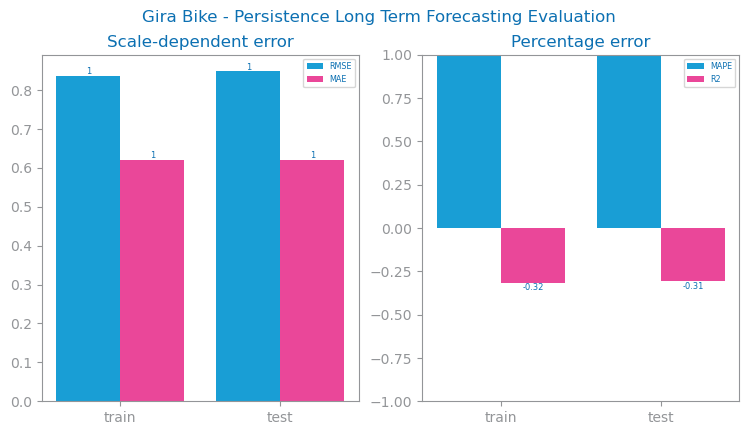

In [17]:

# Fit the Model
model = PersistenceRealistRegressor()
model.fit(trnY)

# Predict the training and testing data
prd_trn_realist = Series(model.predict(trnY), index=train.index)
prd_tst_realist = Series(model.predict(tstY), index=test.index)

# Plot the forecasting evaluation
plot_forecasting_eval(train[target], test[target], prd_trn_realist, prd_tst_realist, title=f"{file_tag} - Persistence Long Term Forecasting Evaluation")
savefig(f"{file_tag}_persitence_realist_evaluation.png")

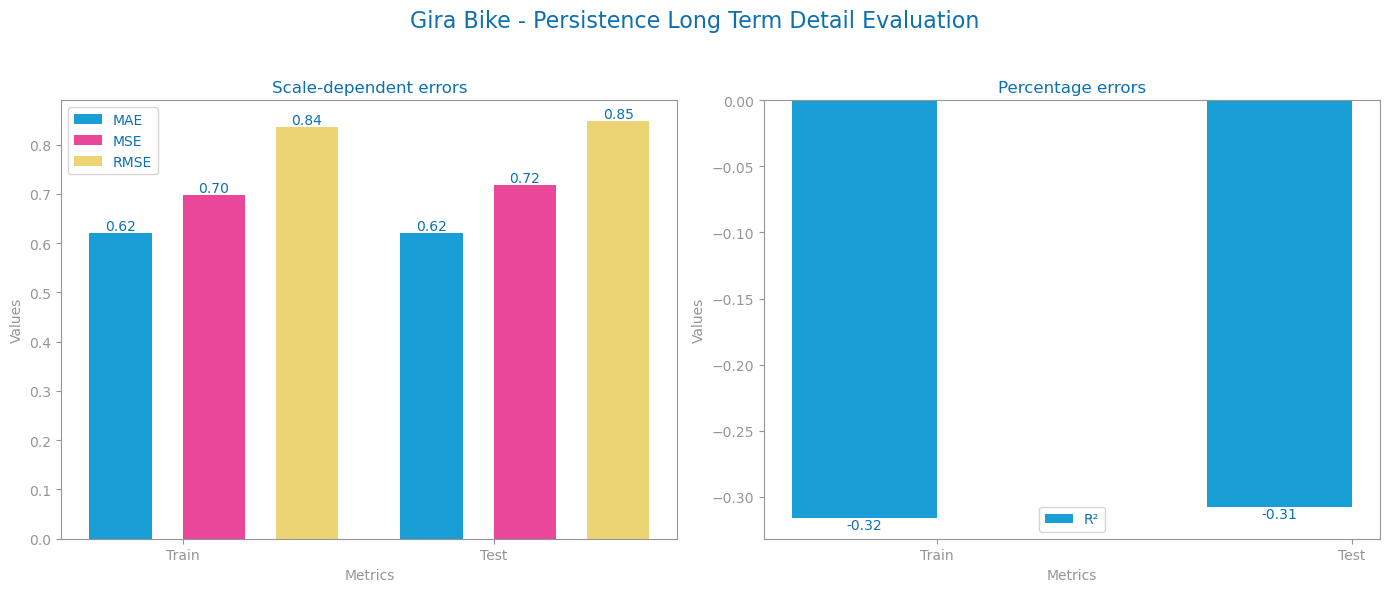

<Figure size 640x480 with 0 Axes>

In [126]:

# Fit the Model
# model = PersistenceRealistRegressor()
model = PersistenceRealistRegressor()
model.fit(trnY)

# Predict the training and testing data
prd_trn_realist = Series(model.predict(trnY), index=train.index)
prd_tst_realist = Series(model.predict(tstY), index=test.index)

# Plot the forecasting evaluation
plot_single_model_evaluation(train[target], test[target], prd_trn_realist, prd_tst_realist, title=f"{file_tag} - Persistence Long Term Detail Evaluation")
savefig(f"images/{file_tag}_persitence_realist_evaluation.png")

#### Persistence Realist Plot

<Axes: xlabel='Date', ylabel='target_station_load_rate'>

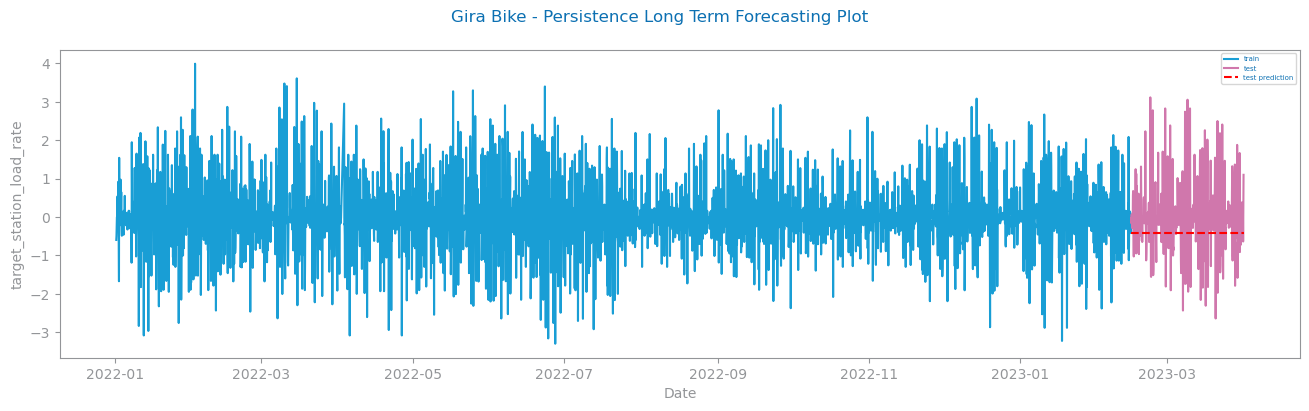

In [18]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst_realist,
    title=f"{file_tag} - Persistence Long Term Forecasting Plot",
    xlabel='Date',
    ylabel=target,
)

In [112]:
train.tail(5)

,temperature_2m,rain_mm,wmo_weather_code,wind_speed_10m,is_holiday_lisbon,target_station_status,target_station_load_rate,station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima,station_load_rate_ Av. Rovisco Pais / Av. Manuel da Maia,station_load_rate_ Praça de Londres,station_load_rate_ Av. Duque de Ávila / Jardim Arco Do Cego,station_load_rate_ Av. Barbosa Du Bocage / Rua Arco do Cego
date,,,,,,,,,,,,
2023-02-14 06:00:00,-0.057250,0.0,0.118018,0.080243,0.0,0.0,0.121602,-0.380399,-0.158129,-0.266006,0.362168,0.000000
2023-02-14 08:00:00,0.229002,0.0,-0.118018,0.320973,0.0,0.0,-0.170243,-1.053412,-2.388157,-1.152692,-0.195766,0.612268
2023-02-14 10:00:00,0.629755,0.0,0.000000,0.353071,0.0,0.0,-0.012160,-1.028331,0.093256,-0.414969,-0.166401,-0.225022
2023-02-14 12:00:00,0.458004,0.0,0.000000,0.609849,0.0,0.0,0.060801,0.075244,0.072983,0.177337,0.332803,-0.225022
2023-02-14 14:00:00,0.305336,0.0,0.177028,-0.064195,0.0,0.0,-0.409394,1.095214,2.104335,-0.294380,0.464945,2.129856


In [113]:
prd_tst_realist.head(5)

date
2023-02-14 16:00:00   -0.409394
2023-02-14 18:00:00   -0.409394
2023-02-14 20:00:00   -0.409394
2023-02-14 22:00:00   -0.409394
2023-02-15 00:00:00   -0.409394
dtype: float64

## Persistence Model Comparison

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-10  # Small constant to avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Calculate performance metrics for each model
persistence_metrics = {
    "Model": ["Persistence One-step Behind", f"Persistence Long Term"],
    "MAE": [
        mean_absolute_error(test[target], prd_tst_opt),
        mean_absolute_error(test[target], prd_tst_realist),
    ],
    "MSE": [
        mean_squared_error(test[target], prd_tst_opt),
        mean_squared_error(test[target], prd_tst_realist),
    ],
    "RMSE": [
        mean_squared_error(test[target], prd_tst_opt, squared=False),
        mean_squared_error(test[target], prd_tst_realist, squared=False),
        
    ],
    "R²": [
        r2_score(test[target], prd_tst_opt),
        r2_score(test[target], prd_tst_realist),
    ],
    "MAPE": [
        mean_absolute_percentage_error(test[target], prd_tst_opt),
        mean_absolute_percentage_error(test[target], prd_tst_realist),
    ]
}

# Create a DataFrame to display the metrics
persistence_performance_df = pd.DataFrame(persistence_metrics)
print(persistence_performance_df)

                         Model       MAE       MSE      RMSE        R²  \
0  Persistence One-step Behind  0.603195  0.955819  0.977660 -0.739111   
1        Persistence Long Term  0.621047  0.718746  0.847789 -0.307758   

           MAPE  
0  2.203948e+10  
1  6.798061e+10  


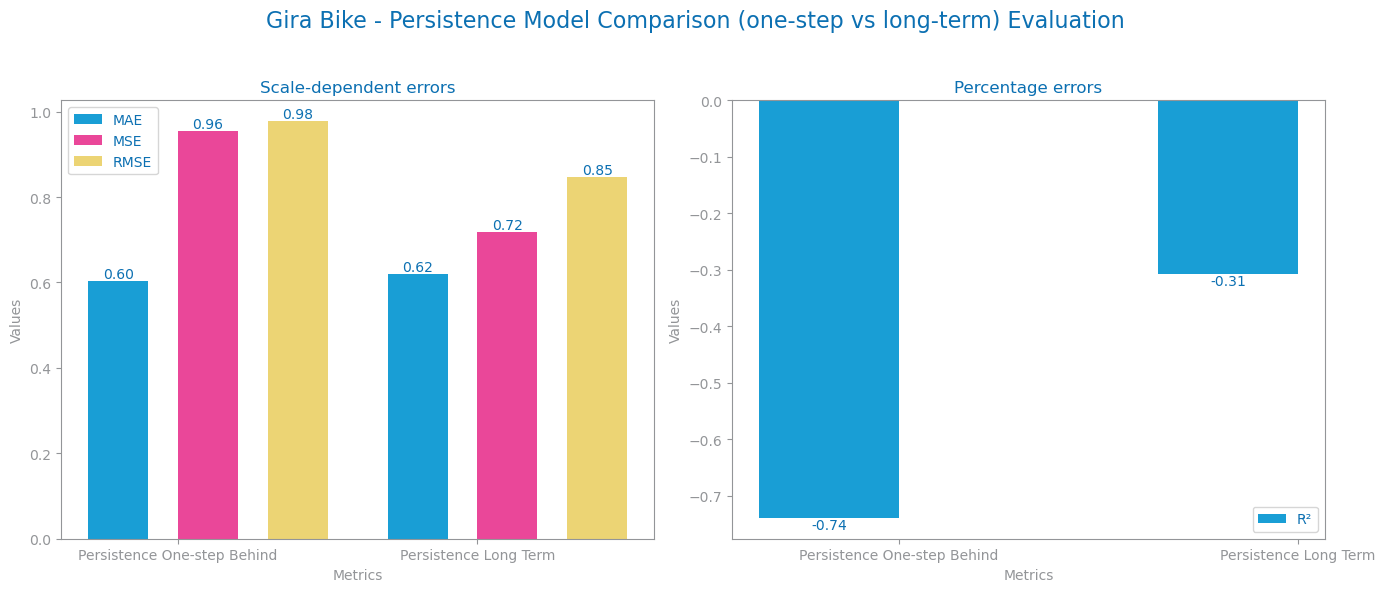

In [21]:
plot_performance_metrics(persistence_metrics, title=f"{file_tag} - Persistence Model Comparison (one-step vs long-term) Evaluation")

## Analysis - Results from Model Implementation

# Exponential Smoothing
- Exponential Smoothing is a simple model that we may say is between the Simple Average and the Peseistence models. We are using its implementation from the statsmodels.tsa package


### Exponential Smoothing Study

In [78]:
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_line_chart
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


def exponential_smoothing_study(train: Series, test: Series, measure: str = "R2"):
    alpha_values = [i / 10 for i in range(1, 10)]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Exponential Smoothing", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    for alpha in alpha_values:
        tool = SimpleExpSmoothing(train)
        model = tool.fit(smoothing_level=alpha, optimized=False)
        prd_tst = model.forecast(steps=len(test))

        eval: float = FORECAST_MEASURES[measure](test, prd_tst)
        # print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (alpha,)
            best_model = model
        yvalues.append(eval)

    print(f"Exponential Smoothing best with alpha={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    plot_line_chart(
        alpha_values,
        yvalues,
        title=f"Exponential Smoothing Study - ({measure})",
        xlabel="alpha",
        ylabel=measure,
        percentage=flag,
    )

    return best_model, best_params

In [79]:

def plot_single_model_evaluation(train: Series, test: Series, prd_train: Series, prd_test: Series, title: str = ""):
    # Calculate performance metrics
    metrics = {
        "MAE": [
            mean_absolute_error(train, prd_train),
            mean_absolute_error(test, prd_test),
        ],
        "MSE": [
            mean_squared_error(train, prd_train),
            mean_squared_error(test, prd_test),
        ],
        "RMSE": [
            mean_squared_error(train, prd_train, squared=False),
            mean_squared_error(test, prd_test, squared=False),
        ],
        "R²": [
            r2_score(train, prd_train),
            r2_score(test, prd_test),
        ]
    }

    # Create a DataFrame from the metrics dictionary
    performance_df = pd.DataFrame(metrics, index=["Train", "Test"]).T
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(title, fontsize=16)
    
    # Plot scale-dependent errors
    scale_dependent_errors = ["MAE", "MSE", "RMSE"]
    scale_dependent_data = performance_df.loc[scale_dependent_errors]
    ax = axs[0]
    ax.set_title("Scale-dependent errors")
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    bar_width = 0.2  # Adjusted bar width for more spacing
    index = np.arange(len(scale_dependent_data.columns))
    for i, metric in enumerate(scale_dependent_data.index):
        bars = ax.bar(index + i * bar_width * 1.5, scale_dependent_data.loc[metric], bar_width, label=metric)
        ax.bar_label(bars, fmt='%.2f')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(scale_dependent_data.columns)
    ax.legend()
    
    # Plot percentage errors
    percentage_errors = ["R²"]
    percentage_data = performance_df.loc[percentage_errors]
    ax = axs[1]
    ax.set_title("Percentage errors")
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    bar_width = 0.35
    index = np.arange(len(percentage_data.columns))
    for i, metric in enumerate(percentage_data.index):
        bars = ax.bar(index + i * bar_width, percentage_data.loc[metric], bar_width, label=metric)
        ax.bar_label(bars, fmt='%.2f')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(percentage_data.columns)
    ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_performance_metrics(metrics: dict, title: str = ""):
    # Create a DataFrame from the metrics dictionary
    performance_df = pd.DataFrame(metrics)
    
    # Separate scale-dependent errors and percentage errors
    scale_dependent_errors = ["MAE", "MSE", "RMSE"]
    percentage_errors = ["R²"]
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(title, fontsize=16)
    
    # Plot scale-dependent errors
    scale_dependent_data = performance_df[["Model"] + scale_dependent_errors].set_index("Model").T
    ax = axs[0]
    ax.set_title("Scale-dependent errors")
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    bar_width = 0.2  # Adjusted bar width for more spacing
    index = np.arange(len(scale_dependent_data.columns))
    for i, metric in enumerate(scale_dependent_data.index):
        bars = ax.bar(index + i * bar_width * 1.5, scale_dependent_data.loc[metric], bar_width, label=metric)
        ax.bar_label(bars, fmt='%.2f')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(scale_dependent_data.columns)
    ax.legend()
    
    # Plot percentage errors
    percentage_data = performance_df[["Model"] + percentage_errors].set_index("Model").T
    ax = axs[1]
    ax.set_title("Percentage errors")
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    bar_width = 0.35
    index = np.arange(len(percentage_data.columns))
    for i, metric in enumerate(percentage_data.index):
        bars = ax.bar(index + i * bar_width, percentage_data.loc[metric], bar_width, label=metric)
        ax.bar_label(bars, fmt='%.2f')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(percentage_data.columns)
    ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [81]:
def exponential_smoothing_study(train: Series, test: Series, measure: str = "R2"):
    # Verificar e tratar valores NaN
    if train.isnull().sum() > 0:
        print("Missing values in train data. Filling NaNs with mean.")
        train = train.fillna(train.mean())
    if test.isnull().sum() > 0:
        print("Missing values in test data. Filling NaNs with mean.")
        test = test.fillna(test.mean())

    alpha_values = [i / 10 for i in range(1, 10)]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Exponential Smoothing", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    for alpha in alpha_values:
        tool = SimpleExpSmoothing(train)
        model = tool.fit(smoothing_level=alpha, optimized=False)
        prd_tst = model.forecast(steps=len(test))

        # Corrigir o índice das previsões
        prd_tst = pd.Series(prd_tst, index=test.index)

        # Verificar se há NaN nas previsões
        if pd.isnull(prd_tst).sum() > 0:
            print("NaN detected in predictions. Filling NaNs with 0.")
            prd_tst = prd_tst.fillna(0)

        eval: float = FORECAST_MEASURES[measure](test, prd_tst)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (alpha,)
            best_model = model
        yvalues.append(eval)

    print(f"Exponential Smoothing best with alpha={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    plot_line_chart(
        alpha_values,
        yvalues,
        title=f"{file_tag} - Exponential Smoothing Study - ({measure})",
        xlabel="alpha",
        ylabel=measure,
        percentage=flag,
    )

    return best_model, best_params


NaN detected in predictions. Filling NaNs with 0.
NaN detected in predictions. Filling NaNs with 0.
NaN detected in predictions. Filling NaNs with 0.
NaN detected in predictions. Filling NaNs with 0.
NaN detected in predictions. Filling NaNs with 0.
NaN detected in predictions. Filling NaNs with 0.
NaN detected in predictions. Filling NaNs with 0.
NaN detected in predictions. Filling NaNs with 0.
NaN detected in predictions. Filling NaNs with 0.
Exponential Smoothing best with alpha=0 -> R2=-6.411230971670179e-06


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/l

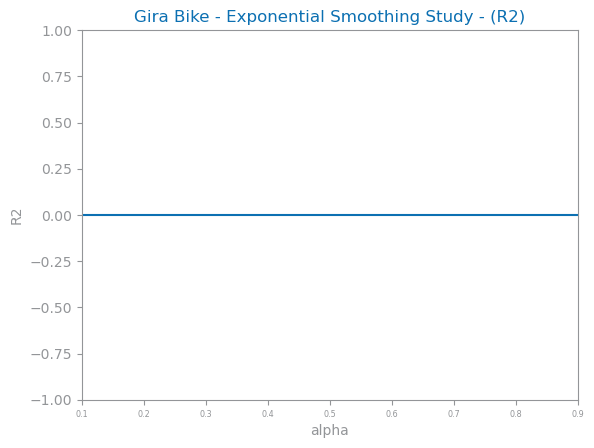

In [82]:
from matplotlib.pyplot import savefig

measure: str = "R2"

best_model, best_params = exponential_smoothing_study(trnY, tstY, measure=measure)
savefig(f"{file_tag}_exponential_smoothing_{measure}_study.png")

### Exponential Study Evaluate

In [134]:
from math import sqrt
from matplotlib.pyplot import subplots
from pandas import Series

def plot_forecasting_eval(trn: Series, tst: Series, prd_trn: Series, prd_tst: Series, title: str = "") -> list:
    # Calculate evaluation metrics
    ev1: dict = {
        "RMSE": [sqrt(FORECAST_MEASURES["MSE"](trn, prd_trn)), sqrt(FORECAST_MEASURES["MSE"](tst, prd_tst))],
        "MAE": [FORECAST_MEASURES["MAE"](trn, prd_trn), FORECAST_MEASURES["MAE"](tst, prd_tst)],
    }
    ev2: dict = {
        "MAPE": [FORECAST_MEASURES["MAPE"](trn, prd_trn), FORECAST_MEASURES["MAPE"](tst, prd_tst)],
        "R2": [FORECAST_MEASURES["R2"](trn, prd_trn), FORECAST_MEASURES["R2"](tst, prd_tst)],
    }

    # Print metric values and sizes of train and test sets
    print(f"\n### Forecasting Evaluation Metrics ({title}) ###")
    print(f"Train size: {len(trn)}")
    print(f"Test size: {len(tst)}")
    print(f"RMSE - Train: {ev1['RMSE'][0]:.4f}, Test: {ev1['RMSE'][1]:.4f}")
    print(f"MAE - Train: {ev1['MAE'][0]:.4f}, Test: {ev1['MAE'][1]:.4f}")
    print(f"MAPE - Train: {ev2['MAPE'][0]:.4f}, Test: {ev2['MAPE'][1]:.4f}")
    print(f"R2 - Train: {ev2['R2'][0]:.4f}, Test: {ev2['R2'][1]:.4f}\n")

    # Plot the metrics
    HEIGHT = 6
    fig, axs = subplots(1, 2, figsize=(1.5 * HEIGHT, 0.75 * HEIGHT), squeeze=True)
    fig.suptitle(title)
    plot_multibar_chart(["train", "test"], ev1, ax=axs[0], title="Scale-dependent error", percentage=False)
    plot_multibar_chart(["train", "test"], ev2, ax=axs[1], title="Percentage error", percentage=True)

    return axs

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


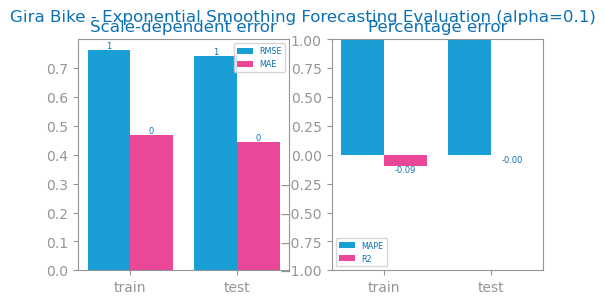

In [83]:
params = best_params["params"]
prd_trn_smooth = best_model.predict(start=0, end=len(trnY) - 1)
prd_tst_smooth = best_model.forecast(steps=len(tstY))
prd_tst_smooth.index = tstY.index

plot_forecasting_eval(trnY, tstY, prd_trn_smooth, prd_tst_smooth, title=f"{file_tag} - Exponential Smoothing Forecasting Evaluation (alpha={params[0]})")
savefig(f"{file_tag}_exponential_smoothing_{measure}_eval.png")

In [139]:
print(prd_trn_smooth.index)
print(tstY.index)


DatetimeIndex(['2022-01-01 14:00:00', '2022-01-01 16:00:00',
               '2022-01-01 18:00:00', '2022-01-01 20:00:00',
               '2022-01-01 22:00:00', '2022-01-02 00:00:00',
               '2022-01-02 02:00:00', '2022-01-02 04:00:00',
               '2022-01-02 06:00:00', '2022-01-02 08:00:00',
               ...
               '2023-02-13 20:00:00', '2023-02-13 22:00:00',
               '2023-02-14 00:00:00', '2023-02-14 02:00:00',
               '2023-02-14 04:00:00', '2023-02-14 06:00:00',
               '2023-02-14 08:00:00', '2023-02-14 10:00:00',
               '2023-02-14 12:00:00', '2023-02-14 14:00:00'],
              dtype='datetime64[ns]', name='date', length=4878, freq=None)
DatetimeIndex(['2023-02-14 16:00:00', '2023-02-14 18:00:00',
               '2023-02-14 20:00:00', '2023-02-14 22:00:00',
               '2023-02-15 00:00:00', '2023-02-15 02:00:00',
               '2023-02-15 04:00:00', '2023-02-15 06:00:00',
               '2023-02-15 08:00:00', '2023-02-15 1

In [140]:
display(prd_trn_smooth.head())
display(prd_tst_smooth.head())

date
2022-01-01 14:00:00   -0.595851
2022-01-01 16:00:00   -0.595851
2022-01-01 18:00:00   -0.584907
2022-01-01 20:00:00   -0.542630
2022-01-01 22:00:00   -0.488367
dtype: float64

date
2023-02-14 16:00:00   -0.033552
2023-02-14 18:00:00   -0.033552
2023-02-14 20:00:00   -0.033552
2023-02-14 22:00:00   -0.033552
2023-02-15 00:00:00   -0.033552
dtype: float64

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


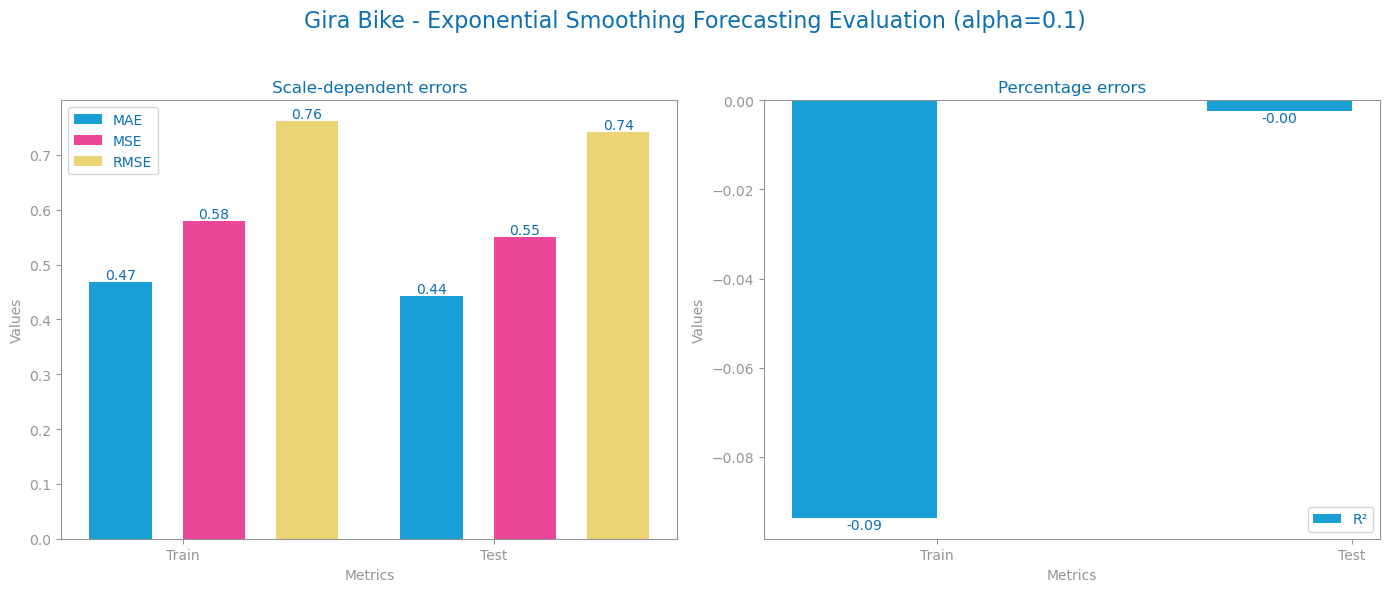

<Figure size 640x480 with 0 Axes>

In [84]:
params = best_params["params"]
prd_trn_smooth = best_model.predict(start=0, end=len(trnY) - 1)
prd_tst_smooth = best_model.forecast(steps=len(tstY))
prd_tst_smooth.index = tstY.index

plot_single_model_evaluation(trnY, tstY, prd_trn_smooth, prd_tst_smooth,  title=f"{file_tag} - Exponential Smoothing Forecasting Evaluation (alpha={params[0]})")
savefig(f"images/{file_tag}_exponential_smoothing_{measure}_eval.png")

### Exponential Smoothing Forecast Plot

<Axes: xlabel='Date', ylabel='target_station_load_rate'>

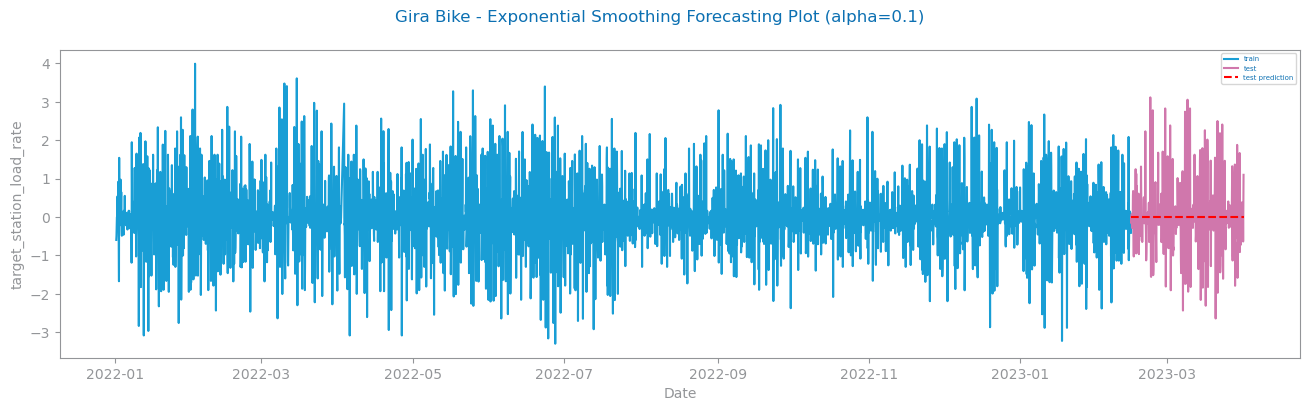

In [86]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - Exponential Smoothing Forecasting Plot (alpha={params[0]})",
    xlabel='Date',
    ylabel=target,
)

## Analysis - Results from Model Implementation

# Rolling Mean

In [73]:
from numpy import mean
from sklearn.base import RegressorMixin



class RollingMeanRegressor(RegressorMixin):
    def __init__(self, win: int = 3):
        super().__init__()
        self.win_size = win
        self.memory: list = []

    def fit(self, X: Series):
        self.memory = X.iloc[-self.win_size :]
        # print(self.memory)
        return

    def predict(self, X: Series):
        estimations = self.memory.tolist()
        for i in range(len(X)):
            new_value = mean(estimations[len(estimations) - self.win_size - i :])
            estimations.append(new_value)
        prd_series: Series = Series(estimations[self.win_size :])
        prd_series.index = X.index
        return prd_series

### Rolling Mean Study

NOT WORKING

Rolling Mean best with win=8 -> R2=-0.00022005135028124734


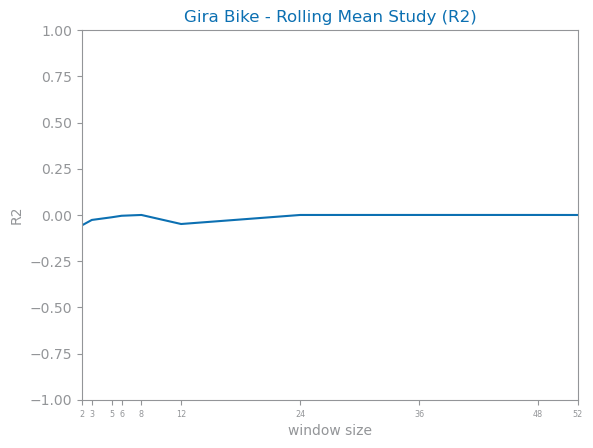

In [35]:
def rolling_mean_study(train: Series, test: Series, measure: str = "R2"):
    # Define the window sizes to study
    #
    # Meio dia (12h) → 6
    # Dois dias (48h) → 24
    # Cinco dias úteis → 60
    # Ciclo diário: 12 - (24h ÷ 2h = 12). = 24h(1 day)
    # Ciclo semanal: 84 -  (7 dias × 24h ÷ 2h = 84)
    # Ciclo quinzenal (15 dias): 180 - (15 × 24h ÷ 2h = 180)
    win_size = (2,3,5,6,8,12, 24, 36,48,52)  # Updated window sizes for bi-hourly data
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Rolling Mean", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    train_series = pd.Series(train)
    test_series = pd.Series(test)
    for w in win_size:
        pred = RollingMeanRegressor(win=w)
        pred.fit(train_series)
        prd_tst = pred.predict(test_series)
        prd_tst = prd_tst[:len(test_series)]  # Ensure the predicted series has the same length as the test series

        eval: float = FORECAST_MEASURES[measure](test_series, prd_tst)
        # print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (w,)
            best_model = pred
        yvalues.append(eval)

    print(f"Rolling Mean best with win={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    plot_line_chart(
        win_size, yvalues, title=f"{file_tag} - Rolling Mean Study ({measure})", xlabel="window size", ylabel=measure, percentage=flag
    )

    return best_model, best_params

measure="R2"
best_model, best_params = rolling_mean_study(trnY, tstY)
savefig(f"images/{file_tag}_rollingmean_{measure}_study.png")

### Rolling Mean Evaluation

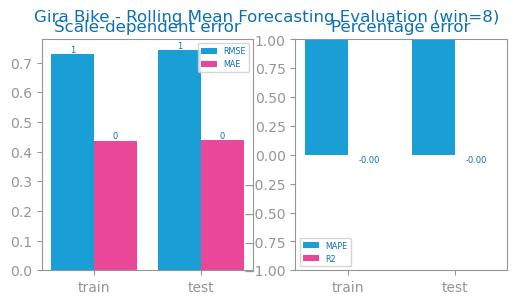

In [74]:
params = best_params["params"]
prd_trn = best_model.predict(pd.Series(trnY))  # Ensure pd.Series is passed
prd_tst = best_model.predict(pd.Series(tstY))  # Ensure pd.Series is passed

plot_forecasting_eval(trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Rolling Mean Forecasting Evaluation (win={params[0]})")
savefig(f"{file_tag}_rolling_mean_{measure}_eval.png")

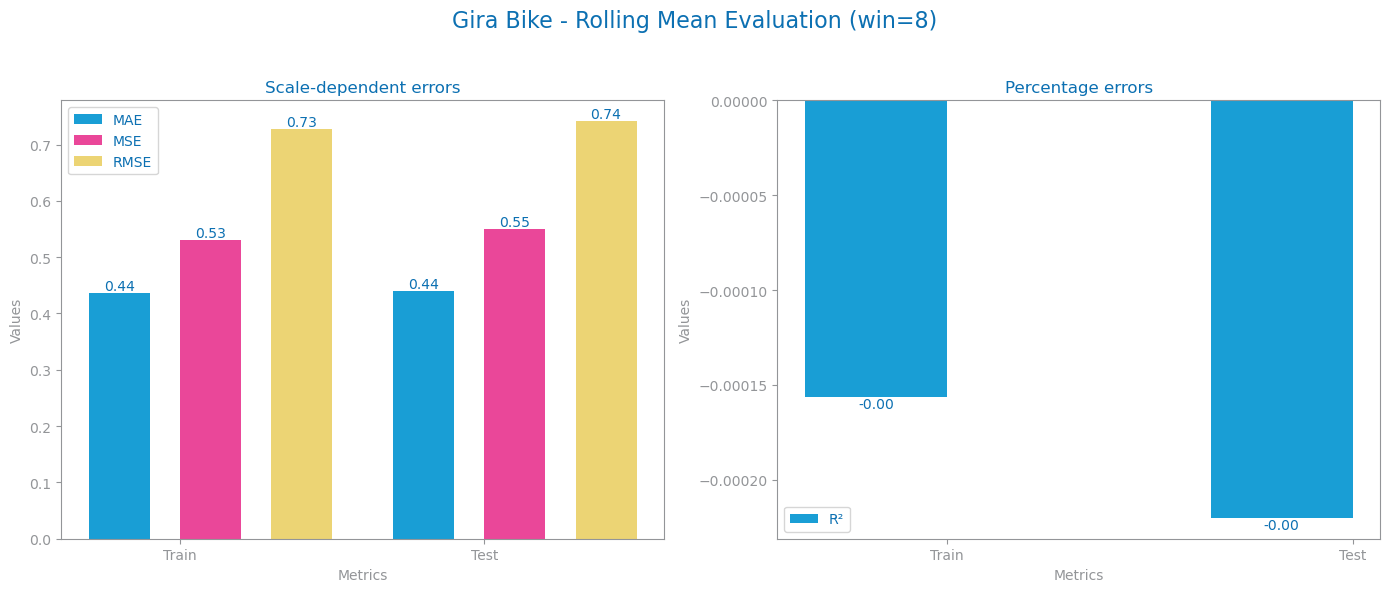

<Figure size 640x480 with 0 Axes>

In [77]:
params = best_params["params"]
prd_trn_roll = best_model.predict(trnY)
prd_tst_roll = best_model.predict(tstY)

plot_single_model_evaluation(trnY, tstY, prd_trn_roll, prd_tst_roll, title=f"{file_tag} - Rolling Mean Evaluation (win={params[0]})")
savefig(f"images/{file_tag}_rolling_mean_{measure}_eval.png")

### Rolling Mean Plot Forecast

<Axes: xlabel='Date', ylabel='target_station_load_rate'>

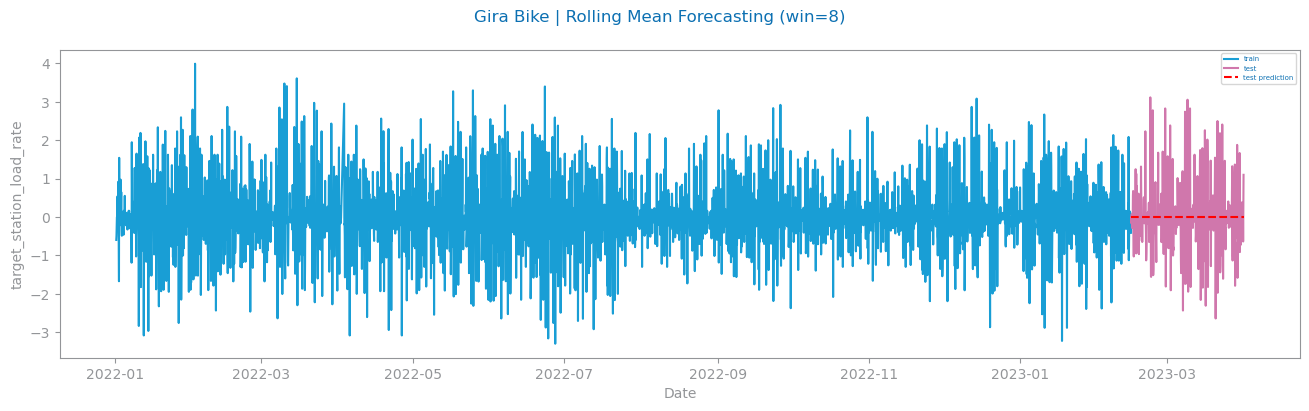

In [71]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst_roll,
    title=f"{file_tag} | Rolling Mean Forecasting (win={params[0]})",
    xlabel='Date',
    ylabel=target,
)

In [67]:
from numpy import mean
from sklearn.base import RegressorMixin



class RollingMeanRegressor(RegressorMixin):
    def __init__(self, win: int = 3):
        super().__init__()
        self.win_size = win
        self.memory: list = []

    def fit(self, X: Series):
        self.memory = X.iloc[-self.win_size :]
        # print(self.memory)
        return

    def predict(self, X: Series):
        estimations = self.memory.tolist()
        for i in range(len(X)):
            new_value = mean(estimations[len(estimations) - self.win_size - i :])
            estimations.append(new_value)
        prd_series: Series = Series(estimations[self.win_size :])
        prd_series.index = X.index
        return prd_series

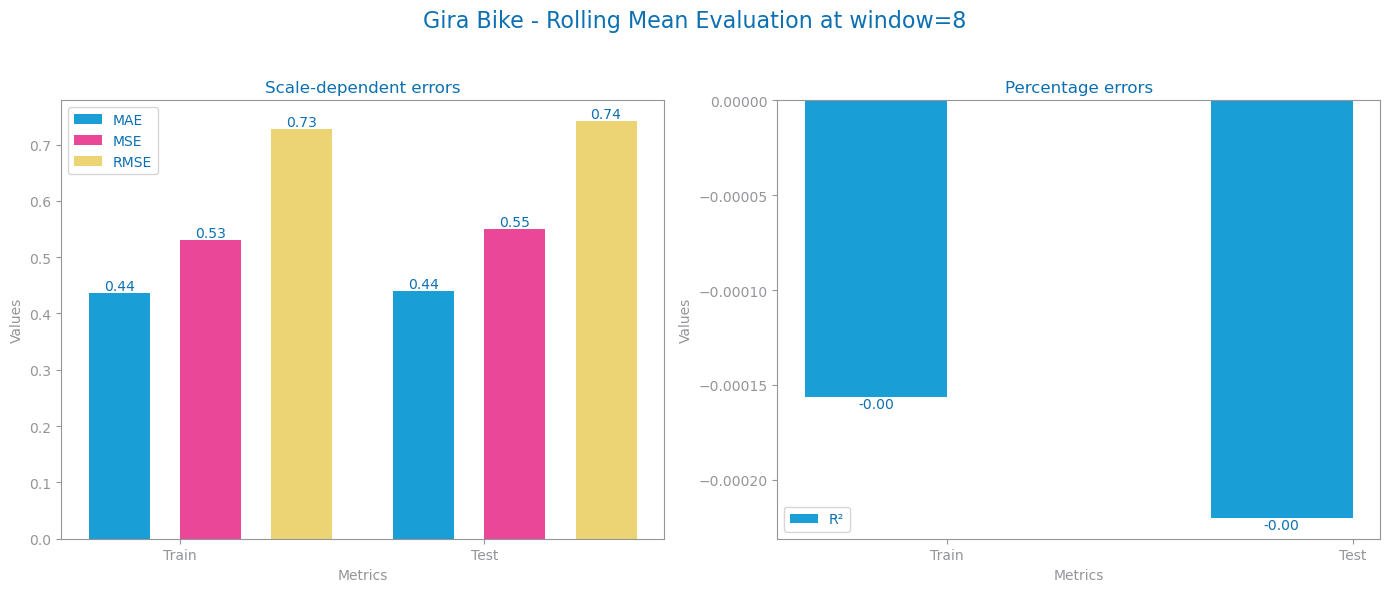

<Figure size 640x480 with 0 Axes>

In [70]:
params = best_params["params"]
prd_trn_roll = best_model.predict(trnY)
prd_tst_roll = best_model.predict(tstY)

plot_single_model_evaluation(trnY, tstY, prd_trn_roll, prd_tst_roll, title=f"{file_tag} - Rolling Mean Evaluation at window={params[0]}")
savefig(f"images/{file_tag}_rolling_mean_{measure}_eval.png")

## Analysis - Results from Model Implementation

# Linear Regression
- Linear Regression models just assume that the time series follows a linear trend, and looks for the line that minimizes the sum of square errors. In order to implement it we just need to use the Linear Regressor sklearn class.

## Linear Regression Evaluate


### Forecasting Evaluation Metrics (Gira Bike - Linear Regression Univariate Forecasting Evaluation) ###
Train size: 4878
Test size: 542
RMSE - Train: 0.7283, Test: 0.7414
MAE - Train: 0.4354, Test: 0.4389
MAPE - Train: 61527624497.4344, Test: 105766843869.9268
R2 - Train: 0.0000, Test: -0.0000



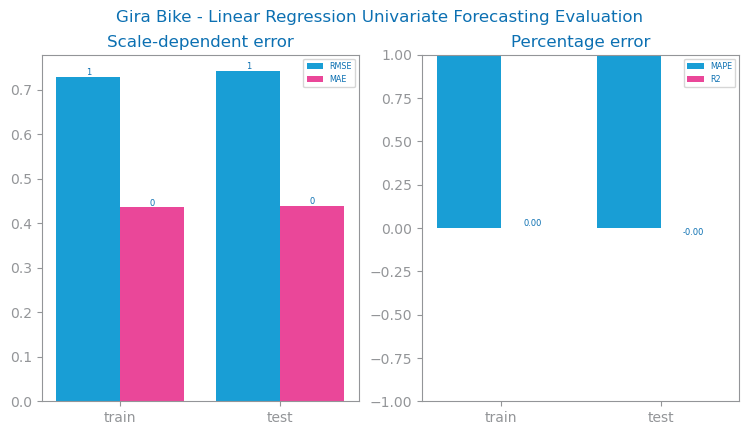

In [24]:
from pandas import Series
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare the training and testing data using the time index as the feature
trnX = arange(len(train)).reshape(-1, 1)
trnY = train[target].to_numpy()
tstX = arange(len(train), len(train+test)).reshape(-1, 1)
tstY = test[target].to_numpy()

# Fit the linear regression model
model_1 = LinearRegression()
model_1.fit(trnX, trnY)

# Predict the training and testing data
prd_trn = Series(model_1.predict(trnX), index=train.index)
prd_tst = Series(model_1.predict(tstX), index=test.index)


# Plot the forecasting evaluation
plot_forecasting_eval(train[target], test[target], prd_trn, prd_tst, title=f"{file_tag} - Linear Regression Univariate Forecasting Evaluation")
savefig(f"{file_tag}_linear_regression_univariate.png")

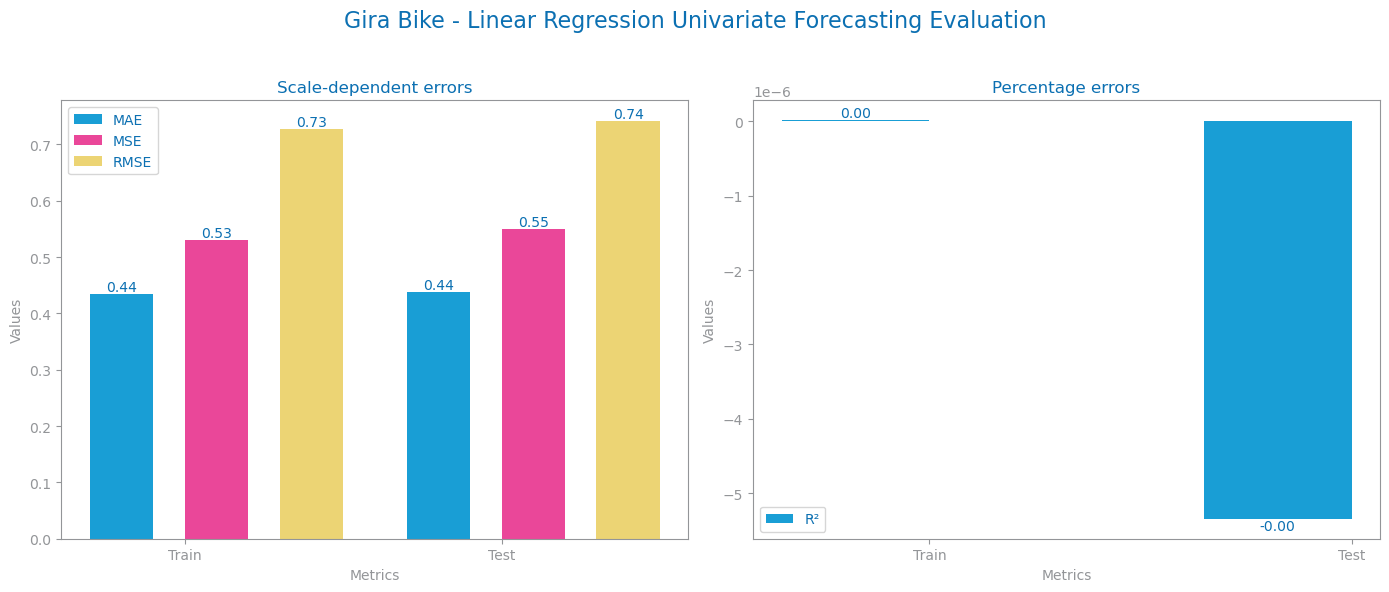

<Figure size 640x480 with 0 Axes>

In [25]:
from pandas import Series
from dslabs_functions import plot_forecasting_eval
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare the training and testing data using the time index as the feature
trnX = arange(len(train)).reshape(-1, 1)
trnY = train[target].to_numpy()
tstX = arange(len(train), len(train+test)).reshape(-1, 1)
tstY = test[target].to_numpy()


# Fit the linear regression model
model_1 = LinearRegression()
model_1.fit(trnX, trnY)

# Predict the training and testing data
prd_trn = Series(model_1.predict(trnX), index=train.index)
prd_tst = Series(model_1.predict(tstX), index=test.index)



# Plot the forecasting evaluation
plot_single_model_evaluation(train[target], test[target], prd_trn, prd_tst, title=f"{file_tag} - Linear Regression Univariate Forecasting Evaluation")
savefig(f"images/{file_tag}_linear_regression_univariate.png")

## Linear Regression Plot

<Axes: xlabel='Date', ylabel='target_station_load_rate'>

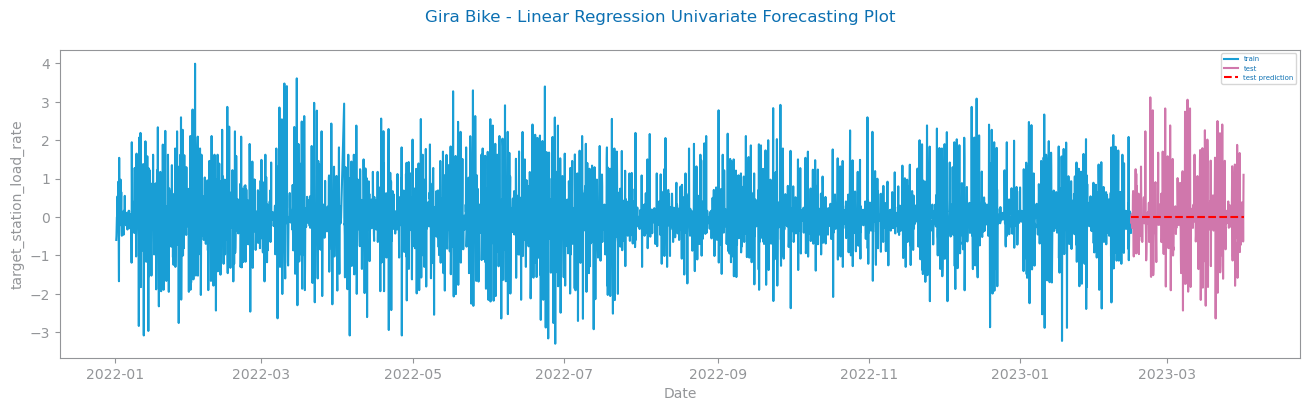

In [26]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - Linear Regression Univariate Forecasting Plot",
    xlabel='Date',
    ylabel=target,
)

## Analysis - Results from Model Implementation

# TO DOs

- Acabar textos para cada modelo "Analysis of the Results from Model Implementation"
- Ver se faz sentido testar outros alpas (pesos das obeservações no tempo)
- Rolling mean testar outras janelas temporais e correr novamente o modelo